## Úvod do lineární algebry

### 0. Setup

#### 0.1. Importy

In [1]:
import numpy as np
from random import choice, randint
import timeit
from typing import Callable
import matplotlib.pyplot as plt

#### 0.2. Kontrolní funkce
Užito při kontrole validity generované matice (0.4.).

In [2]:
def diagonally_dominant_assertion(matrix:np.ndarray) -> bool:
    for row in range(len(matrix)):
        test_val = matrix[row, row]
        matrix[row, row] = 0
        if test_val <= sum(matrix[row, :]):
            #print(f"{test_val} <= {sum(matrix[row, :])} ({matrix[row, :]})")
            return False

        matrix[row, row] = test_val
        
    return True

def linearly_independant_assertion(matrix:np.ndarray) -> bool:
    #print(f"Determinant: {np.linalg.det(matrix)}")
    return np.linalg.det(matrix) != 0

#### 0.3. Prvočísla
Užito při generaci matic (0.4.).

In [3]:
def test_indivisibilty(divided:int, divisors:list) -> bool:
    border = divided ** (1/2)
    for number in divisors:
        if number > border:
            break

        if divided % number == 0:
            return False
    
    return True

def generate_primes(number_of_primes:int) -> list:
    initials = [3]
    multiplier = 1
    while len(initials) <= number_of_primes:
        level = 6 * multiplier
        multiplier += 1
        if test_indivisibilty(level - 1, initials):
            initials.append(level-1)
        if test_indivisibilty(level + 1, initials):
            initials.append(level + 1)

    return initials

#### 0.4. Generování vhodných matic

In [4]:
def generate_matrix(dimensions:int, primes:list | None = None) -> tuple[np.ndarray, np.ndarray]: # Generuje matici a odpověď pro jednodušší použití
    foundation = np.zeros((dimensions,dimensions), dtype=int)
    if primes == None:
        primes = generate_primes(dimensions)
    else:
        primes = primes[:]

    for row in range(dimensions):
        current_prime = choice(primes)
        primes.remove(current_prime)
        foundation[row, row] = (current_prime * sum(range(2, dimensions +1))) + (2 * dimensions)
        for modifier in range(1, dimensions):
            foundation[row, (row + modifier) % dimensions] = current_prime * (dimensions - modifier) + 1

    assert linearly_independant_assertion(foundation), "This matrix is not linearly independant."
    assert diagonally_dominant_assertion(foundation), "This matrix is not diagonally dominant."

    answers = np.array([randint(1,200) for i in range(dimensions)])

    return (foundation, answers)

### 1. Přímá metoda: Gausovská eliminace
Kód je silně inspirován dostupným příkladem na GitHubu.

In [5]:
def gaussian_elimination(matrix:np.ndarray, answers:np.ndarray) -> np.ndarray:
    mat_with_answers = np.column_stack((matrix, answers)).astype(float)
    #display(mat_with_answers)

    lines = len(matrix)
    #print(lines)

    for row in range(lines):
        mat_with_answers[row] /= mat_with_answers[row, row] # Potenciální dělení nulou, pls fix (reordering?)
        for second_row in range(row + 1, lines):
            mat_with_answers[second_row] -= mat_with_answers[second_row, row] * mat_with_answers[row]

    #display(mat_with_answers)

    solution = np.zeros(lines, dtype=float)

    for backstep in range(lines - 1, -1, -1):
        solution[backstep] = mat_with_answers[backstep, -1] - np.dot(mat_with_answers[backstep,:-1], solution)

    return solution 

#### 1.1. Testování validity funkce
Porovnání výsledku oproti knihovnové funkci numpy.linalg.solve.

In [6]:
test_array, test_answers = generate_matrix(5)

In [7]:
gaussian_elimination(test_array, test_answers)

array([0.12479589, 1.54596447, 0.42828227, 0.5160091 , 0.21127217])

In [8]:
np.linalg.solve(test_array, test_answers)

array([0.12479589, 1.54596447, 0.42828227, 0.5160091 , 0.21127217])

### 2. Iterační metoda: Gauss-Seidlova metoda
Kód je opět silně inspirován kódem z GitHubu.

In [9]:
def gauss_seidel(matrix:np.ndarray, answers:np.ndarray, diff:float = 1/(10**8)) -> np.ndarray:

    current_iter = np.ones(len(matrix))
    strict_upper = np.triu(matrix, k=1)
    lower = np.tril(matrix, k=0)
    inverted_lower = np.linalg.inv(lower)
    
    T = np.matmul(-inverted_lower, strict_upper)
    C = np.matmul (inverted_lower, answers)

    last_iter = np.zeros(len(matrix))

    iteration = 1
    while np.max(abs(current_iter - last_iter)) > diff:
    #for i in range(20):
        last_iter = current_iter
        current_iter = np.matmul(T, current_iter, dtype=float) + C
        #print(f"Iterace {iteration}: {current_iter}")
        iteration += 1

    return current_iter

#### 2.1. Testování validity funkce

In [10]:
gauss_seidel(test_array, test_answers)

array([0.12479589, 1.54596447, 0.42828227, 0.5160091 , 0.21127217])

In [11]:
np.linalg.solve(test_array, test_answers)

array([0.12479589, 1.54596447, 0.42828227, 0.5160091 , 0.21127217])

### 3. Porovnání přístupů

In [12]:
def testing_round(method:Callable, matrix:np.ndarray, answers:np.ndarray, repeat:int = 50):
    tested_func = lambda : method(matrix, answers)
    times = timeit.timeit(tested_func, number=repeat)
    return times


def test_matrix_function(repeat:int = 10, max_dimension:int = 251) -> dict:
    direct_dict = {}
    iterative_dict = {}
    primes = generate_primes(max_dimension)
    for dimension in range(3, max_dimension):
        print("Generating dim:" + str(dimension))
        tested_matrix, tested_answers = generate_matrix(dimension, primes)
        print("Testing")
        direct_dict.update({dimension:testing_round(gaussian_elimination, tested_matrix, tested_answers)})
        iterative_dict.update({dimension:testing_round(gauss_seidel, tested_matrix, tested_answers)})
        if dimension % 10 == 0:
            print(f"{str(direct_dict[dimension])}, {str(iterative_dict[dimension])}")

    return (direct_dict, iterative_dict)

In [13]:
direct_results, iterative_results = test_matrix_function(repeat=5,max_dimension=101)

Generating dim:3
Testing
Generating dim:4
Testing
Generating dim:5
Testing
Generating dim:6
Testing
Generating dim:7
Testing
Generating dim:8
Testing
Generating dim:9
Testing
Generating dim:10
Testing
0.011507800008985214, 0.024829000001773238
Generating dim:11
Testing
Generating dim:12
Testing
Generating dim:13
Testing
Generating dim:14
Testing
Generating dim:15
Testing
Generating dim:16
Testing
Generating dim:17
Testing
Generating dim:18
Testing
Generating dim:19
Testing
Generating dim:20
Testing
0.03511440000147559, 0.0324553999962518
Generating dim:21
Testing
Generating dim:22
Testing
Generating dim:23
Testing
Generating dim:24
Testing
Generating dim:25
Testing
Generating dim:26
Testing
Generating dim:27
Testing
Generating dim:28
Testing
Generating dim:29
Testing
Generating dim:30
Testing
0.0648254999978235, 0.08774170000106096
Generating dim:31
Testing
Generating dim:32
Testing
Generating dim:33
Testing
Generating dim:34
Testing
Generating dim:35
Testing
Generating dim:36
Testing


c:\Users\Matej\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Generating dim:59
Testing
Generating dim:60
Testing
0.23680940001213457, 0.24808569999004249
Generating dim:61
Testing
Generating dim:62
Testing
Generating dim:63
Testing
Generating dim:64
Testing
Generating dim:65
Testing
Generating dim:66
Testing
Generating dim:67
Testing
Generating dim:68
Testing
Generating dim:69
Testing
Generating dim:70
Testing
0.3949348000023747, 0.1601996999961557
Generating dim:71
Testing
Generating dim:72
Testing
Generating dim:73
Testing
Generating dim:74
Testing
Generating dim:75
Testing
Generating dim:76
Testing
Generating dim:77
Testing
Generating dim:78
Testing
Generating dim:79
Testing
Generating dim:80
Testing
0.5021685999963665, 0.2714455000095768
Generating dim:81
Testing
Generating dim:82
Testing
Generating dim:83
Testing
Generating dim:84
Testing
Generating dim:85
Testing
Generating dim:86
Testing
Generating dim:87
Testing
Generating dim:88
Testing
Generating dim:89
Testing
Generating dim:90
Testing
0.6492705999989994, 0.40769550000550225
Generatin

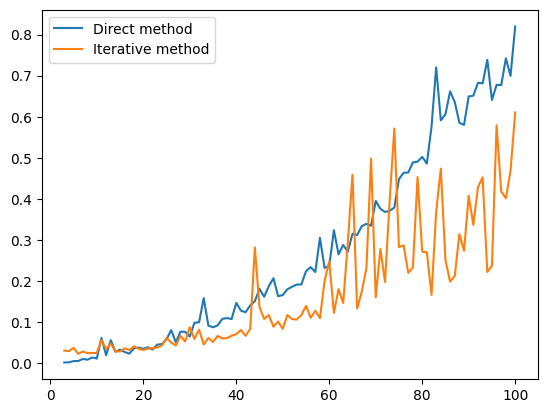

In [17]:
plt.plot(direct_results.keys(), direct_results.values())
plt.plot(iterative_results.keys(), iterative_results.values())
plt.legend(["Direct method", "Iterative method"])

plt.show()

#### Poznámka
V dané úrovni jsou metody testovány 5x na stejné matici. Tímto vznikají hroty v grafu: Je vygenerována matice, která iterační metodě moc nesedne, a vlivem tohoto iterační metoda trvá déle.

Nicméně v grafu jde vidět, že maximální dimenze, do které je přímá metoda efektivnější (nebo stejně efektivní) se je přibližně 20 (tolerance 5).